<h1>New plant disease dataset classification using CNN</h1>
<p>Within the GitHub repo there are many alternatives of the dataset including augmented and split data. I will be using the raw unchanged colour data within this project which can be found under the raw and then color directories.</p>
<p>Within this dataset I am going to begin by only focusing on the Apple plant images and their conditions to reduce the number of classification classes</p>

In the future to improve model convert jpeg images into tfrec files but not for now because we just need to make the model.

Issues running into:
*   Can't run model on tpu without using google sdk because the tpu can't access local files to run them



# Data gathering and sorting
<p>Move desired 4 folders into the apples only folder to be used, Apples_only is in the content folder if you lose it again</p>

In [2]:
! git clone https://github.com/spMohanty/PlantVillage-Dataset
! cd PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 16.36 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [3]:
%ls

PlantVillage-Dataset/  sample_data/


In [4]:
# Make Apples_only directory in the content route
%mkdir -p Apples_only

In [5]:
# Copy desired data from original directory into Apples_only
%mv /content/PlantVillage-Dataset/raw/color/Apple___Apple_scab /content/Apples_only/Scab
%mv /content/PlantVillage-Dataset/raw/color/Apple___Black_rot /content/Apples_only/Black_rot
%mv /content/PlantVillage-Dataset/raw/color/Apple___Cedar_apple_rust /content/Apples_only/Rust
%mv /content/PlantVillage-Dataset/raw/color/Apple___healthy /content/Apples_only/Healthy

In [6]:
%cd Apples_only/

/content/Apples_only


In [7]:
%ls

Black_rot/  Healthy/  Rust/  Scab/


Import .json file with label mappings

In [8]:
# %cd ..

# from google.colab import files
# files.upload()

# Setting up environment

In [9]:
# Module importing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, warnings
import shutil
import cv2
import math
import re

from functools import partial
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
print("Tensorflow version", tf.__version__)

Tensorflow version 2.8.0


# Make .csv file for the labels

In [10]:
# Making a csv file and dataframe of one hot encoded data
root_dir = '/content/Apples_only'
classes = ['Scab', 'Black_rot', 'Rust', 'Healthy']

scab_substring = "Scab"
black_rot_substring = "JR_FrgE.S"
healthy_substring = "RS_HL"
rust_substring = "Rust"

# Create datasframe to for data to be converted into a .csv
df = pd.DataFrame(columns = ['image_id', 'label'])
# print(df)
for images in os.listdir(root_dir + '/Scab/'):
  fullstring = images
  int_dic = {"image_id":fullstring, 'label':0}
  df = df.append(int_dic, ignore_index=True)

for images in os.listdir(root_dir + '/Black_rot/'):   
  int_dic = {"image_id":fullstring, 'label':1}
  df = df.append(int_dic, ignore_index=True)

for images in os.listdir(root_dir + '/Rust/'):   
  int_dic = {"image_id":fullstring, 'label':2}
  df = df.append(int_dic, ignore_index=True)

for images in os.listdir(root_dir + '/Healthy/'):   
  int_dic = {"image_id":fullstring, 'label':3}
  df = df.append(int_dic, ignore_index=True)

In [11]:
# This may not be necessary as we are not moving the data from anywhere to anywheree it's all staying in house
df.to_csv('/content/labels.csv', header=True, index=False)

# Make train and test folders

In [12]:
for i in classes:
  os.makedirs(root_dir + '/train_images/' + i)
  os.makedirs(root_dir + '/test_images/' + i)
  source = root_dir + '/' + i

  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.1
  train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(1 - test_ratio))])

  train_FileNames = [source + '/' + name for name in train_FileNames.tolist()]
  test_FileNames = [source + '/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, root_dir + '/train_images/' + i)
  
  for name in test_FileNames:
    shutil.copy(name, root_dir + '/test_images/' + i)

In [13]:
# %mv /content/Apples_only/train_images/Black_rot/* /content/Apples_only/train_images
# %mv /content/Apples_only/train_images/Healthy/* /content/Apples_only/train_images
# %mv /content/Apples_only/train_images/Rust/* /content/Apples_only/train_images
# %mv /content/Apples_only/train_images/Scab/* /content/Apples_only/train_images
# %rmdir /content/Apples_only/train_images/Black_rot
# %rmdir /content/Apples_only/train_images/Healthy
# %rmdir /content/Apples_only/train_images/Rust
# %rmdir /content/Apples_only/train_images/Scab

# %mv /content/Apples_only/test_images/Black_rot/* /content/Apples_only/test_images
# %mv /content/Apples_only/test_images/Healthy/* /content/Apples_only/test_images
# %mv /content/Apples_only/test_images/Rust/* /content/Apples_only/test_images
# %mv /content/Apples_only/test_images/Scab/* /content/Apples_only/test_images
# %rmdir /content/Apples_only/test_images/Black_rot
# %rmdir /content/Apples_only/test_images/Healthy
# %rmdir /content/Apples_only/test_images/Rust
# %rmdir /content/Apples_only/test_images/Scab

# Detect TPU
<p>If number of replicas is 1, it means that TPU is not enabled within the notebook.</p>

In [14]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Detect a GPU
For those days when you don't want to wait an age for a cpu to run but it's too late to troubleshout a tpu

In [15]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Setting up varaibles
*   Autotune delivers the input to the TPU more efficiently.

*   strategy.num_replicas_in_sync determines the way the loss function should be calculated.



In [16]:
autotune = tf.data.experimental.AUTOTUNE
batch_size = 16 * strategy.num_replicas_in_sync
# IMAGE_SIZE = [512, 512]
# classes = ['0', '1', '2', '3']
# epochs = 25

# Load the image data into Python
<h3>Decode images and format into tfrecords for the tpu</h3>

In [17]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '/content/Apples_only/train_images',
    labels='inferred',
    label_mode='int',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '/content/Apples_only/test_images',
    labels='inferred',
    label_mode='int',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 2852 files belonging to 4 classes.
Found 319 files belonging to 4 classes.


In [18]:
# # Loading in images (not tfrecs)

# train = ImageDataGenerator(rescale = 1/255)
# test = ImageDataGenerator(rescale = 1/255)

# train_dataset = train.flow_from_directory("/content/Apples_only/train_images/",
#                                           target_size = (200,200),
#                                           batch_size = 50,
#                                           class_mode = "categorical")

# test_dataset = test.flow_from_directory("/content/Apples_only/test_images/",
#                                           target_size = (200,200),
#                                           batch_size = 50,
#                                           class_mode = "categorical")

# print(train_dataset)

In [19]:
# train_dataset.class_indices

In [20]:
# train_dataset.classes

In [21]:
# def decode_image(image):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0 # Normalise image values between 0 and 1
#     image = tf.reshape(image, [*image_size, 3])
#     return image

In [22]:
# def read_tfrecord(example, labeled):
#     tfrecord_format = {
#         "image": tf.io.FixedLenFeature([], tf.string),
#         "target": tf.io.FixedLenFeature([], tf.int64)
#     } 

#     example = tf.io.parse_single_example(example, tfrecord_format)
#     image = decode_image(example['image'])
#     if labeled:
#         label = tf.cast(example['target'], tf.int32)
#         return image, label
#     idnum = example['image_name']
#     return image, idnum

In [23]:
# def load_dataset(filenames, labeled=True, ordered=False):
#     ignore_order = tf.data.Options()
#     if not ordered:
#         ignore_order.experimental_deterministic = False # disable order, increase speed
#     dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=autotune) # automatically interleaves reads from multiple files
#     dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
#     dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=autotune)
#     return dataset

In [24]:
# train_filenames, val_filenames = train_test_split(
#     tf.io.gfile.glob(root_dir + '/train_images/*'),
#     test_size=0.35, random_state=5
# )

# test_filenames = tf.io.gfile.glob(root_dir + '/test_images/*')

# print(train_filenames)

# Data Augmentation

In [25]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

# Brief Exploratory Data Analysis (EDA)

In [26]:
# print(get_training_dataset())
# print(get_training_dataset().take(3))
# # for image, label in get_training_dataset().take(3):
# # #     print("image:",image)
# #     print("label:", label)

In [27]:
# print("Training data shapes:")
# for image, label in get_training_dataset().take(3):
#     print(image.numpy().shape, label.numpy().shape)
# print("Training data label examples:", label.numpy())

# print("Validation data shapes:")
# for image, label in get_validation_dataset().take(3):
#     print(image.numpy().shape, label.numpy().shape)
# print("Validation data label examples:", label.numpy())

# print("Test data shapes:")
# for image, idnum in get_test_dataset().take(3):
#     print(image.numpy().shape, idnum.numpy().shape)
# print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

# Define data loading methods

In [28]:
# def get_training_dataset():
#     dataset = load_dataset(train_filenames, labeled=True)  
#     dataset = dataset.map(data_augment, num_parallel_calls=autotune)  
#     dataset = dataset.repeat()
#     dataset = dataset.shuffle(2048)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(autotune)
#     return dataset

# def get_validation_dataset(ordered=False):
#     dataset = load_dataset(val_filenames, labeled=True, ordered=ordered) 
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.cache()
#     dataset = dataset.prefetch(autotune)
#     return dataset

# def get_test_dataset(ordered=False):
#     dataset = load_dataset(test_filenames, labeled=False, ordered=ordered)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(autotune)
#     return dataset

# Make the model

In [29]:
with strategy.scope():

  model = keras.Sequential([
      # Block One
      layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                    input_shape=[128, 128, 3]),
      layers.MaxPool2D(),

      # Block Two
      layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
      layers.MaxPool2D(),

      # Block Three
      layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
      layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
      layers.MaxPool2D(),

      # Head
      layers.Flatten(),
      layers.Dense(6, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(4, activation='softmax'),
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       1

Model Train

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


In [32]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
45/45 [==============================] - 20s 181ms/step - loss: 1.2763 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.1891 - val_sparse_categorical_accuracy: 0.5172
Epoch 2/50
45/45 [==============================] - 7s 153ms/step - loss: 1.1513 - sparse_categorical_accuracy: 0.4786 - val_loss: 1.0521 - val_sparse_categorical_accuracy: 0.5204
Epoch 3/50
45/45 [==============================] - 7s 152ms/step - loss: 0.9875 - sparse_categorical_accuracy: 0.5536 - val_loss: 0.8269 - val_sparse_categorical_accuracy: 0.6395
Epoch 4/50
45/45 [==============================] - 7s 147ms/step - loss: 0.7745 - sparse_categorical_accuracy: 0.6238 - val_loss: 0.7078 - val_sparse_categorical_accuracy: 0.6646
Epoch 5/50
45/45 [==============================] - 7s 148ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.6477 - val_sparse_categorical_accuracy: 0.7116
Epoch 6/50
45/45 [==============================] - 7s 147ms/step - loss: 0.6092 - sparse_categoric

In [33]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
#     loss='sparse_categorical_crossentropy',
#     metrics=['sparse_categorical_accuracy']
# )

# history = model.fit(
#     ds_train,
#     validation_data=ds_valid,
#     epochs=40,
#     verbose=0
# )

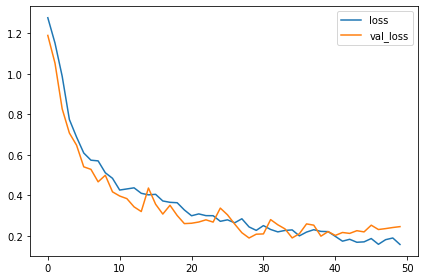

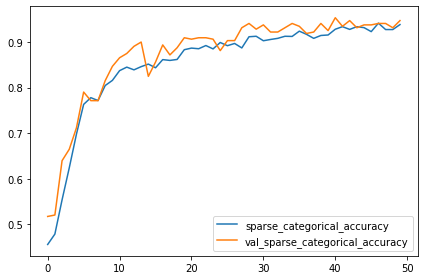

In [34]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

In [53]:
ds_test= image_dataset_from_directory(
    '/content/folder',
    # labels='inferred',
    label_mode='int',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False
)
ds_test = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

probabilities = model.predict(ds_test)
print(probabilities)
print(sum(probabilities[0]))

Found 2 files belonging to 2 classes.
[[1.1971517e-03 9.9805439e-01 7.4354262e-04 4.9738078e-06]
 [7.9201913e-05 7.5956859e-07 9.3279606e-01 6.7124017e-02]]
1.0000000533395905





---



---


---


# Ideas that aren't being used at the moment

In [35]:
## Importing the images

# train_image = []
# for i in tqdm(range(train.shape[0])):
#   img = image.load_img("/content/Apples_only/train/"+train['ID'][i], target_size=(128,128,3))
#   img = image.img_to_array(img)
#   img = image/255
#   train_image.append(img)

# X = np.array(train_image)

In [36]:
# plt.imshow(X[2])

In [37]:
## Another method of importing the data
# image_path = /content/Apples_only/train/

# def create_dataset(img_folder):

#   img_data_array = []
#   class_name = []

#   for dir1 in os.listdir(image_path):
#     for file in os.listdir(os.paht.join(image_path, dir1)):

#       image_path = os.path.join(image_path, dir1, file)
#       image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
#       image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
#       image = np.array(image)
#       image = image.astype('float32')
#       image /= 255
#       img_data_array.append(image)
#       class_name.append(dir1)
#   return img_data_array, class_name

# img_data, class_name = create_dataset(/content/Apples_only/train_data)


In [38]:
###### Putting images into a dictionary of their class

# scab_dir = root_dir + '/train/Scab'
# black_rot_dir = root_dir + '/train/Black_rot'
# rust_dir = root_dir + '/train/Rust'
# healthy_dir = root_dir + '/train/Healthy'

# # Get a list of all images
# scab_images = scab_dir.glob('*.jpeg')
# black_rot_images = black_rot_dir.glob('*.jpeg')
# rust_images = rust_dir.glob('*.jpeg')
# healthy_images = healthy_dir.glob('*.jpeg')

# # Empty list to put each of the imgaes into with their class
# train_data = []

# for img in scab_images:
#   train_data.append((img, 1))

# for img in black_rot_images:
#   train_data.append((img, 2))

# for img in rust_images:
#   train_data.append((img, 3))

# for img in healthy_images:
#   train_data.append((img, 4))

In [39]:
## Cell for showing an image from a dataset

# image_path = '/content/Apples_only/train/Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG'
# image = tf.io.read_file(image_path)
# image = tf.io.decode_jpeg(image)

# plt.figure(figsize=(6, 6))
# plt.imshow(tf.squeeze(image), cmap='gray')
# plt.axis('off')
# plt.show();

# # Select dataframe from file structure
# # df = /content/PlantVillage-Dataset/raw/color

In [40]:
# train.head()

In [41]:
# # Set reproducability 
# def set_seed(seed=31415):
#     np.random.seed(seed)
#     tf.random.set_seed(seed)

# set_seed(seed=31415)

# # Load training and validation sets
# ds_train_ = image_dataset_from_directory(
#     '/content/Apples_only/train',
#     labels='inferred',
#     label_mode='categorical',
#     image_size=[128, 128],
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=True,
# )
# ds_valid_ = image_dataset_from_directory(
#     '/content/Apples_only/test',
#     labels='inferred',
#     label_mode='categorical',
#     image_size=[128, 128],
#     interpolation='nearest',
#     batch_size=64,
#     shuffle=False,
# )

# # Data Pipeline, converting images into tensors
# def convert_to_float(image, label):
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#     return image, label

# AUTOTUNE = tf.data.experimental.AUTOTUNE

# ds_train = (
#     ds_train_
#     .map(convert_to_float)
#     .cache()
#     .prefetch(buffer_size=AUTOTUNE)
# )
# ds_valid = (
#     ds_valid_
#     .map(convert_to_float)
#     .cache()
#     .prefetch(buffer_size=AUTOTUNE)
# )

